In [72]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import os as os
import statsmodels.api as sm
import statsmodels.regression.linear_model as lm
sys.path.append('../../')
import Constants as c
import Utilities as utils
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import RidgeCV
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
sns.set_style("darkgrid")
%matplotlib inline

In [73]:
regressors = {
  "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
  "RandomForestRegressor": RandomForestRegressor(random_state=0),
  "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
  "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
  "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
  "KNeighborsRegressor": KNeighborsRegressor(),
  "IsotonicRegression": IsotonicRegression(),
  "KernelRidge": KernelRidge(),
  "MLPRegressor": MLPRegressor(random_state=0),
  "SVR": SVR(),
  "LinearRegression": LinearRegression(),
  "RidgeCV": RidgeCV()
}

transformers = {
  "RobustScaler": RobustScaler(),
  "StandardScaler": StandardScaler(),
  "MinMaxScaler": MinMaxScaler()
}

regressor = regressors["LinearRegression"]
transformer = transformers["RobustScaler"]

In [74]:
project_name = "linux"
# file = "../../output/{0}_version_metrics.csv".format(project_name)
file = "../../output/{0}_version_metrics_major_versions.csv".format(project_name)
df = pd.read_csv(file)

df["E_Line"] = df["E_Line"].astype(str).astype(int)
df["E_Module"] = df["E_Module"].astype(str).astype(int)
df = df.rename(columns={"T_Line": "T_Line_Original", "T_Module": "T_Module_Original"})
df["T_Line"] = df["T_Line_Original"].shift()
df["T_Module"] = df["T_Module_Original"].shift()
df = df[[c.VERSION, c.NT, c.NO, "E_Line", "E_Module", c.T_LINE, c.T_MODULE]]

print(len(df))

if df.isna().values.any():
    df.fillna(0, inplace=True)

df = df.apply(lambda x: np.log1p(x) if np.issubdtype(x.dtype, np.number) else x)

df.replace([np.inf, -np.inf], 0, inplace=True)
df = utils.remove_outlier(df, "E_Line")
df = utils.remove_outlier(df, "E_Module")
df = utils.remove_outlier(df, c.NT)
df = utils.remove_outlier(df, c.NO)

print(len(df))

df.head()

76
61


,Version,NT,NO,E_Line,E_Module,T_Line,T_Module
12,v2.6.24,7.410952,9.071193,13.935156,9.185638,15.963330,10.022647
13,v2.6.25,7.575072,9.283591,13.965052,9.179469,15.997007,10.045985
14,v2.6.26,7.444249,9.080118,13.798276,9.063695,16.038178,10.077903
15,v2.6.27,7.428927,9.178747,14.315123,9.508146,16.057469,10.097038
16,v2.6.28,7.365813,9.012499,13.976359,9.208839,16.080383,10.100451


In [75]:
# print out a correlation matrix of our data frame
corr = df.corr(method="spearman")

# display it
display(corr)

,NT,NO,E_Line,E_Module,T_Line,T_Module
NT,1.000000,0.292050,0.406341,0.324338,-0.081554,-0.079994
NO,0.292050,1.000000,-0.103120,0.666526,0.839714,0.840878
E_Line,0.406341,-0.103120,1.000000,0.187837,-0.289847,-0.286832
E_Module,0.324338,0.666526,0.187837,1.000000,0.603913,0.606822
T_Line,-0.081554,0.839714,-0.289847,0.603913,1.000000,0.999471
T_Module,-0.079994,0.840878,-0.286832,0.606822,0.999471,1.000000


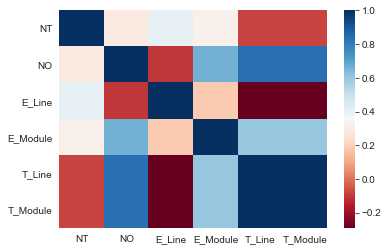

In [76]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

Text(0.5, 1.0, 'NT vs. E_Module - linux')

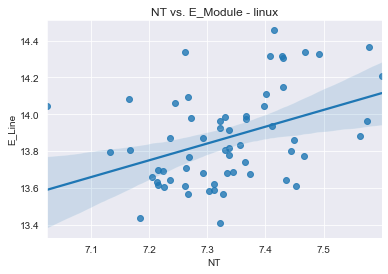

In [77]:
sns.set_style("darkgrid")
line_effort = sns.regplot(x=c.NT, y="E_Line", data=df)
plt.title('NT vs. E_Module - {0}'.format(project_name))

Text(0.5, 1.0, 'NO vs. E_Module - linux')

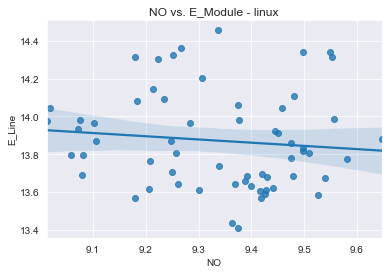

In [78]:
sns.set_style("darkgrid")
line_effort = sns.regplot(x=c.NO, y="E_Line", data=df)
plt.title('NO vs. E_Module - {0}'.format(project_name))

Text(0.5, 1.0, 'NT vs. E_Module - linux')

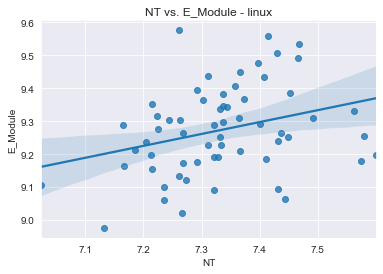

In [79]:
sns.set_style("darkgrid")
line_effort = sns.regplot(x=c.NT, y="E_Module", data=df)
plt.title('NT vs. E_Module - {0}'.format(project_name))

Text(0.5, 1.0, 'NO vs. E_Module - linux')

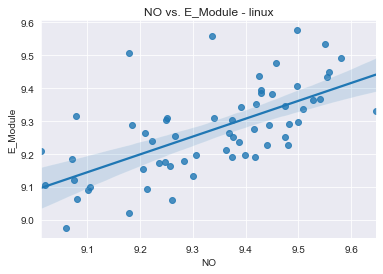

In [80]:
sns.set_style("darkgrid")
line_effort = sns.regplot(x=c.NO, y="E_Module", data=df)
plt.title('NO vs. E_Module - {0}'.format(project_name))

Text(0.5, 1.0, 'T_Module vs. E_Module - linux')

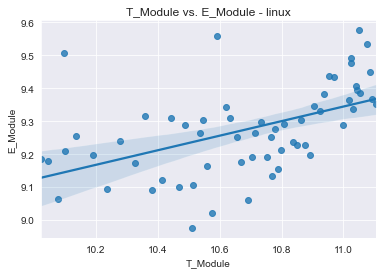

In [81]:
sns.set_style("darkgrid")
line_effort = sns.regplot(x=c.T_MODULE, y="E_Module", data=df)
plt.title('T_Module vs. E_Module - {0}'.format(project_name))

In [82]:
X = df[[c.NT, c.NO]]
Y = df['E_Line']

splits = 10
num_records = len(X)

if num_records <= splits:
    splits = num_records

pipeline = Pipeline(steps=[('scaler', transformer), ('predictor', regressor)])
model = TransformedTargetRegressor(regressor=pipeline, transformer=transformer)
model.fit(X, Y)

kfold = model_selection.KFold(n_splits=splits)
predictions = cross_val_predict(model, X, Y, cv=kfold)
# Interpreting Restuls:  https://www.youtube.com/watch?v=U7D1h5bbpcs  

In [83]:
# 1st Assumption of Linearity:  Multicollinearity Test
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=X.columns).T

,NT,NO
vif,2717.809348,2717.809348


In [84]:
results = utils.create_percent_error_df
results = utils.create_percent_error_df(Y, predictions)
results['Version'] = np.arange(results.__len__())
results

,Observed,Predicted,Difference,Percent_Error,Version
12,13.94,14.11,0.17,0.01,0
13,13.97,14.19,0.23,0.02,1
14,13.80,14.14,0.34,0.02,2
15,14.32,14.07,0.24,0.02,3
16,13.98,14.08,0.11,0.01,4
...,...,...,...,...,...
70,13.61,13.96,0.35,0.03,56
72,14.34,13.92,0.42,0.03,57
73,13.99,13.81,0.18,0.01,58
74,13.67,13.83,0.15,0.01,59


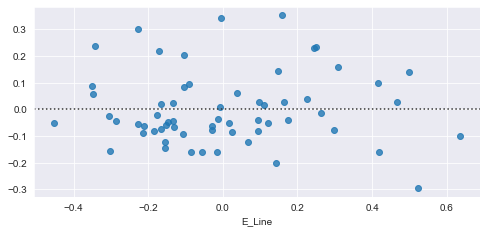

In [85]:
# 2nd Assumption of Linearity:  Homoscedasticity Test
fig, ax = plt.subplots(figsize=(8,3.5))
pred_val = predictions
true_val = Y
residuals = true_val - pred_val
sns.residplot(residuals, pred_val)

In [86]:
residuals.mean()

0.003663000981692739

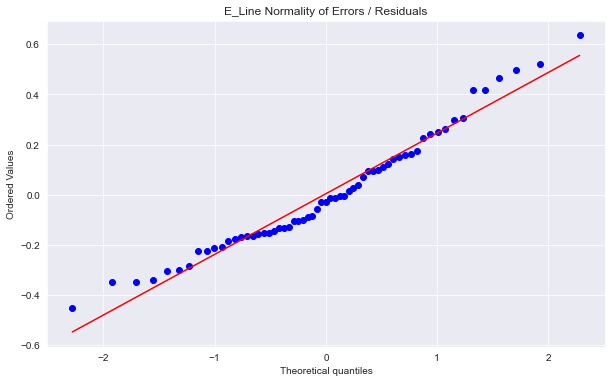

In [87]:
# 3rd Assumption of Linearity:  Normality of Errors / Residuals Test
fig, ax = plt.subplots(figsize=(10,6))
st.probplot(residuals, dist='norm', plot=plt)
plt.title('E_Line Normality of Errors / Residuals')
plt.show()

Text(0.5, 1.0, 'E_Line Normality of Errors / Residuals')

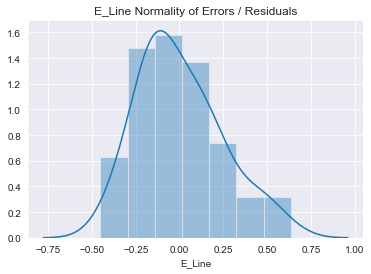

In [88]:
# 3rd Assumption of Linearity:  Normality of Errors / Residuals Test
sns.distplot(residuals)
plt.title('E_Line Normality of Errors / Residuals')

In [89]:
pred25 = utils.calculate_PRED(0.25, results, c.PERCENT_ERROR)
print("PRED (25): " + "{:.2%}".format(pred25))

pred50 = utils.calculate_PRED(0.50, results, c.PERCENT_ERROR)
print("PRED (50): " + "{:.2%}".format(pred50))

PRED (25): 100.00%
PRED (50): 100.00%


In [90]:
metrics.mean_absolute_error(Y, predictions)

0.1930664503909014

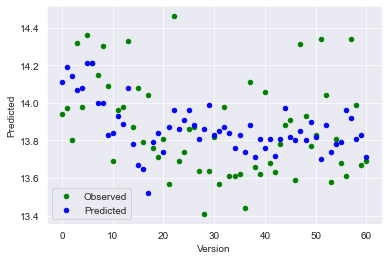

In [91]:
ax = results.plot(kind='scatter', x='Version', y='Observed', c='green', label='Observed')
results.plot(kind='scatter', x='Version', y='Predicted', c='blue', label='Predicted', ax=ax)

In [92]:
# partialRegPlot = plt.figure(figsize=(15,8))
# partialRegPlot = sm.graphics.regressionplots.plot_partregress_grid(model, fig=partialRegPlot)

In [93]:
# regPlotNC = plt.figure(figsize=(15,8))
# regPlotNC = sm.graphics.regressionplots.plot_regress_exog(model, c.NT, fig=regPlotNC)

In [94]:
# regPlotNO = plt.figure(figsize=(15,8))
# regPlotNO = sm.graphics.regressionplots.plot_regress_exog(model, c.NO, fig=regPlotNO)

In [95]:
X = df[[c.NT, c.NO, c.T_MODULE]]
Y = df['E_Module']

pipeline = Pipeline(steps=[('scaler', transformer), ('predictor', regressor)])
model = TransformedTargetRegressor(regressor=pipeline, transformer=transformer)
fitted_values = model.fit(X, Y)

kfold = model_selection.KFold(n_splits=splits)
predictions = cross_val_predict(model, X, Y, cv=kfold)

In [96]:
# 1st Assumption of Linearity:  Multicollinearity Test
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=X.columns).T

,NT,NO,T_Module
vif,6771.492178,25306.143431,7508.519173


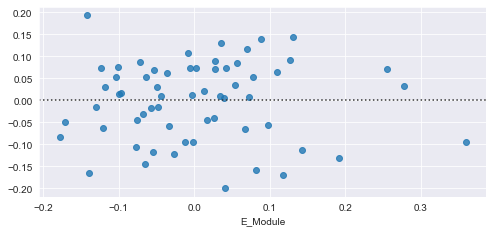

In [97]:
# 2nd Assumption of Linearity:  Homoscedasticity Test
fig, ax = plt.subplots(figsize=(8,3.5))
pred_val = predictions
true_val = Y
residuals = true_val - pred_val
sns.residplot(residuals, pred_val)

In [98]:
residuals.mean()

0.004978977362700389

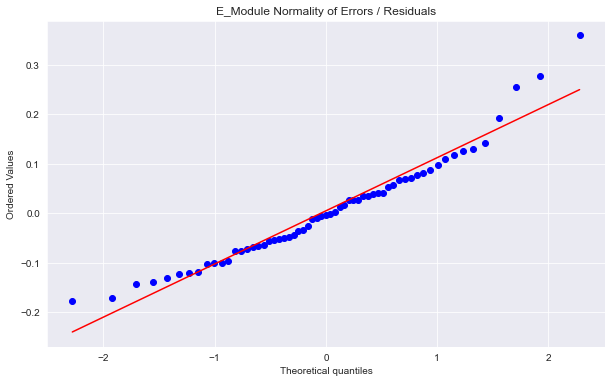

In [99]:
# 3rd Assumption of Linearity:  Normality of Errors / Residuals Test
fig, ax = plt.subplots(figsize=(10,6))
st.probplot(residuals, dist='norm', plot=plt)
plt.title('E_Module Normality of Errors / Residuals')
plt.show()

Text(0.5, 1.0, 'E_Module Normality of Errors / Residuals')

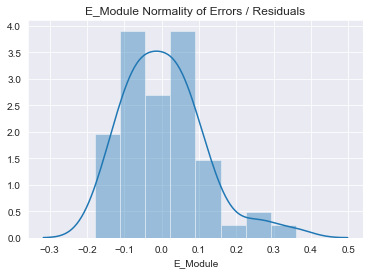

In [100]:
# 3rd Assumption of Linearity:  Normality of Errors / Residuals Test
sns.distplot(residuals)
plt.title('E_Module Normality of Errors / Residuals')

In [101]:
data = {}
data[c.OBSERVED] = Y.round(2)
results = utils.create_percent_error_df(Y, predictions)
results['Version'] = np.arange(results.__len__())
results

,Observed,Predicted,Difference,Percent_Error,Version
12,9.19,9.10,0.08,0.01,0
13,9.18,9.21,0.03,0.00,1
14,9.06,9.13,0.07,0.01,2
15,9.51,9.15,0.36,0.04,3
16,9.21,9.09,0.12,0.01,4
...,...,...,...,...,...
70,9.39,9.36,0.03,0.00,56
72,9.53,9.40,0.13,0.01,57
73,9.45,9.38,0.07,0.01,58
74,9.37,9.38,0.01,0.00,59


In [102]:
pred25 = utils.calculate_PRED(0.25, results, c.PERCENT_ERROR)
print("PRED (25): " + "{:.2%}".format(pred25))

pred50 = utils.calculate_PRED(0.50, results, c.PERCENT_ERROR)
print("PRED (50): " + "{:.2%}".format(pred50))

PRED (25): 100.00%
PRED (50): 100.00%


In [103]:
metrics.mean_absolute_error(Y, predictions)

0.08288727665947479

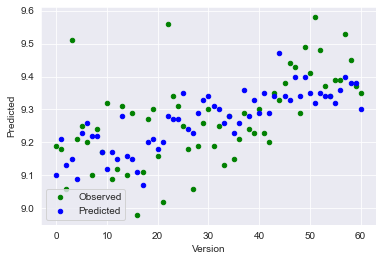

In [104]:
ax = results.plot(kind='scatter', x='Version', y='Observed', c='green', label='Observed')
results.plot(kind='scatter', x='Version', y='Predicted', c='blue', label='Predicted', ax=ax)

In [105]:
# partialRegPlot = plt.figure(figsize=(15,8))
# partialRegPlot = sm.graphics.regressionplots.plot_partregress_grid(model, fig=partialRegPlot)

In [106]:
# regPlotNC = plt.figure(figsize=(15,8))
# regPlotNC = sm.graphics.regressionplots.plot_regress_exog(model, c.NT, fig=regPlotNC)

In [107]:
# regPlotNO = plt.figure(figsize=(15,8))
# regPlotNO = sm.graphics.regressionplots.plot_regress_exog(model, c.NO, fig=regPlotNO)